# Hadrick-Prescott filter

Ovaj filter dekomponuje vremensku seriju na trend i cikličnost prema loss funkciji koja se minimizuje:

 $$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$$

In [3]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('AirPassengers.csv')

In [17]:
df['putnici']=df['#Passengers']

In [18]:
df = df.drop('#Passengers', axis=1)

In [19]:
df.head()

,Month,putnici
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<AxesSubplot:>

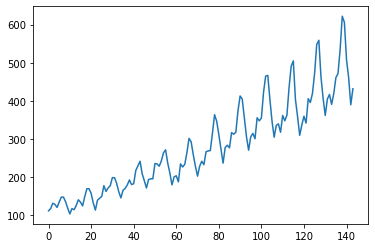

In [11]:
df['putnici'].plot()

In [20]:
index=pd.date_range('1949', periods=144, freq='M')
index

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')

In [22]:
df=df.set_index(index)

In [23]:
df=df.drop('Month', axis=1)

In [24]:
df

,putnici
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461
1960-11-30,390


In [5]:
from statsmodels.tsa.filters.hp_filter import hpfilter

<AxesSubplot:>

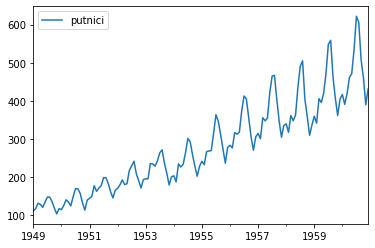

In [25]:
df.plot()

In [34]:
cikličnost, trend = hpfilter(df['putnici'], lamb=800)

In [28]:
import matplotlib.pyplot as plt

In [35]:
df['trend']=trend
df['cikličnost']=cikličnost

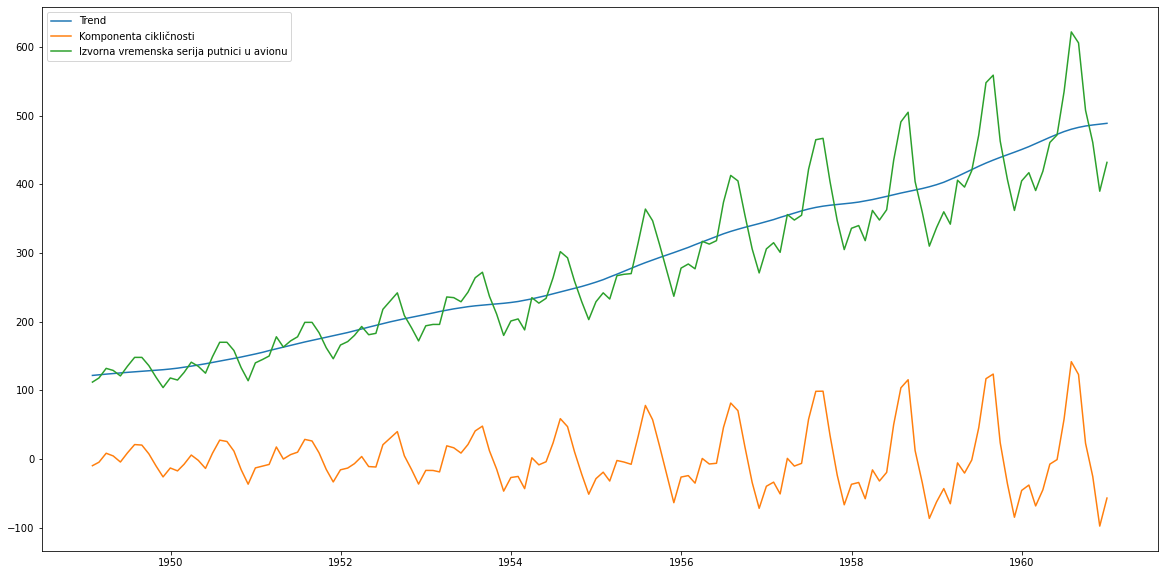

In [42]:
plt.figure(figsize=(20, 10))
plt.plot(df['trend'], label='Trend')
plt.plot(df['cikličnost'], label='Komponenta cikličnosti')
plt.plot(df['putnici'], label='Izvorna vremenska serija putnici u avionu')
plt.legend()

In [37]:
pwd

'/Users/vjovanovic/Desktop/Vezbanja'

In [38]:
dfe = pd.read_csv('/Users/vjovanovic/Desktop/Portilla Time Series/Data/macrodata.csv',index_col=0,parse_dates=True)
dfe.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [40]:
cikličnost, trend = hpfilter(dfe['realgdp'], lamb=1600)

In [41]:
dfe['trend']=trend
dfe['cikličnost']=cikličnost

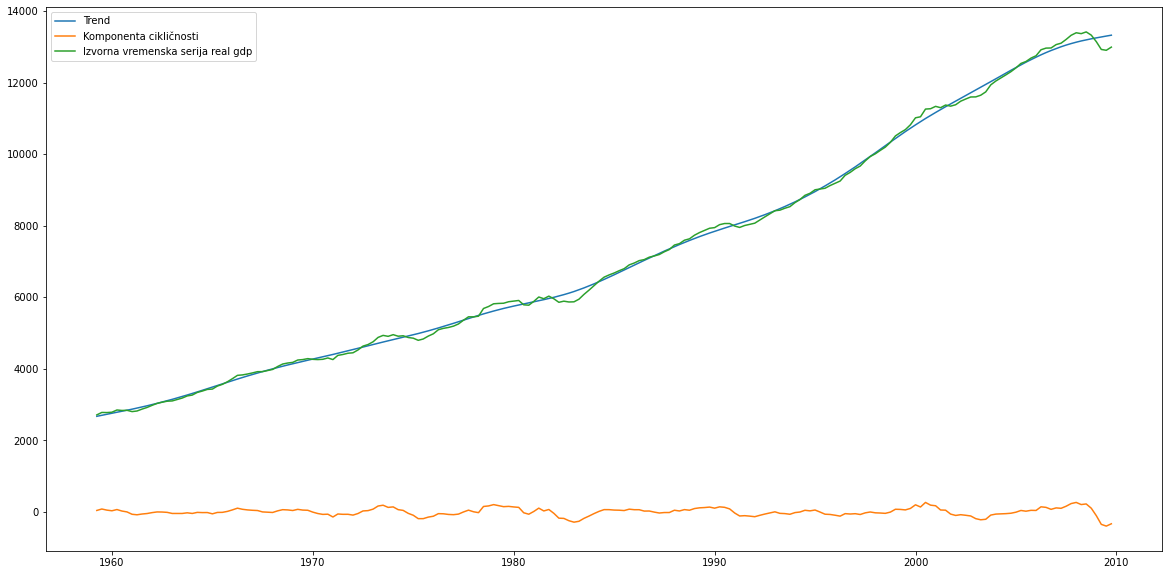

In [43]:
plt.figure(figsize=(20, 10))
plt.plot(dfe['trend'], label='Trend')
plt.plot(dfe['cikličnost'], label='Komponenta cikličnosti')
plt.plot(dfe['realgdp'], label='Izvorna vremenska serija real gdp')
plt.legend()

<AxesSubplot:>

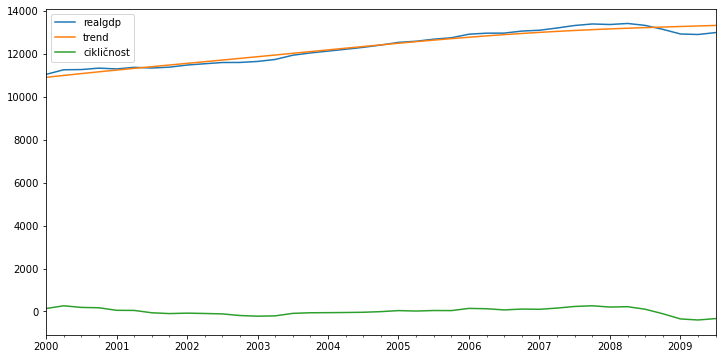

In [49]:
dfe[['realgdp', 'trend', 'cikličnost']]['2000-01-01':].plot(figsize=(12,6))

# EWMA

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [63]:
df['EWMA alfa=0.2']=df['putnici'].ewm(alpha=0.2).mean()
df['EWMA alfa=0.6']=df['putnici'].ewm(alpha=0.6).mean()
df['EWMA 6 month']=df['putnici'].ewm(span=6).mean()
df['EWMA 12 month']=df['putnici'].ewm(span=12).mean()

<AxesSubplot:>

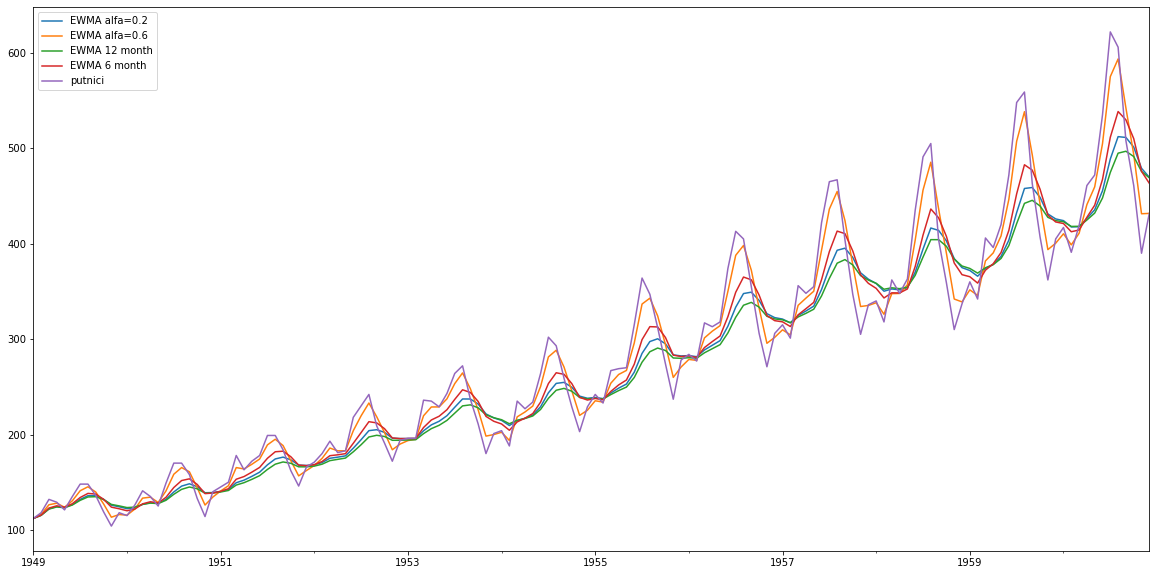

In [66]:
df[['EWMA alfa=0.2', 'EWMA alfa=0.6', 'EWMA 12 month', 'EWMA 6 month','putnici']].plot(figsize=(20,10))